# Sensitivity Sampling and Analysis

Sensitivity is a measure of the proportion of variance in some defined value that is explained by a particular input parameter.

### This notebook demonstrates the use of the Sobol sampling and associated sensitivity analysis of the model

see https://en.wikipedia.org/wiki/Variance-based_sensitivity_analysis  and https://en.wikipedia.org/wiki/Sobol_sequence for some background
    
####     - It specifies the Sobol sampling (SobolOptimizer) as part of the Optimizer specifications (OptimizerSpec)
####     - This is is place of the standard SCE optimisation used typically in calibration


#### It assumes the opimisation/sampling is beign undertaken on a cluster (e.g. NCI) and runs catchment/cell simulations in parallel on differing compute nodes

## Sensitivity analysis background

Sensitivity cannot be measured directly, but rather must be estimated from a sample distribution.
This estimation requires selection of a sampling scheme (Sobol sequence here), and corresponding variance estimation functions.
See the following reference for further background: 


   - ***Andrea Saltelli, Paola Annoni, Ivano Azzini, Francesca Campolongo, Marco Ratto, Stefano Tarantola. Variance based sensitivity analysis of model output. Design and estimator for the total sensitivity index, In Computer Physics Communications, Volume 181, Issue 2, 2010, Pages 259-270, ISSN 0010-4655, https://doi.org/10.1016/j.cpc.2009.09.018.***

 

This notebook goes through the following steps:

1. Import required libraries
2. Set up calibration configuration <br>

   - 2.1 Catchments to be calibrated
   - 2.2 Period to calibrate over<br>
   - 2.3 Import model/get default mapping<br>
   - 2.4 Setting the optimizer - SobolOptimizer<br>
   - 2.5 Define objective functions<br>
   - 2.6 Update forcing paths (optional)<br>
   - 2.7 Combine into a specification dictionary<br>
   
   
3. Run 'calibration'; ie sampling<br>
4. Visualise sensitivity outputs

### 1. Import required libraries

In [1]:
from awrams.calibration.support import *
from os.path import join
from awrams.utils import gis
from awrams.utils import datetools as dt
from awrams.utils import extents
from awrams.utils.settings_manager import get_settings
import h5py

### 2. Define calibration configuration

#### 2.1 Select catchment extents

In [2]:
# Point to some catchment data

from awrams.utils.gis import ShapefileDB, CATCHMENT_SHAPEFILE

calvalshapefile = ShapefileDB(CATCHMENT_SHAPEFILE)

# Define the extenst of the calibration
def_extent = extents.get_default_extent() 

In [3]:
 ## Create a dict with multiple extents
extent_map = {}
cal_catchments = ['109001','111101','112102']

for catchment in cal_catchments:
    extent_map[catchment] = calvalshapefile.get_extent_by_field('StationID', catchment, parent_extent=def_extent)
    
extent_map

{'109001': origin: -16.4,145.2, shape: (3, 5), cell_size: 0.05,
 '111101': origin: -17.35,145.7, shape: (4, 8), cell_size: 0.05,
 '112102': origin: -17.65,145.8, shape: (4, 3), cell_size: 0.05}

#### 2.2 Specify running period

In [4]:
run_period = dt.dates('2009 - 2011')
eval_period = dt.dates('2009 - 2011')

#### 2.3 Import model/get default mapping

In [5]:
# Import the model and point to input climate data
from awrams.models.awral.model import AWRALModel
from awrams.utils.nodegraph import nodes, graph
model = AWRALModel()
node_mapping = model.get_default_mapping()

#Check model inputs
def change_path_to_forcing(imap):
    from awrams.utils.nodegraph import nodes
    from os.path import join
    from os import getcwd
    from awrams.models.settings import TRAINING_DATA_PATH

    data_path = TRAINING_DATA_PATH + '/climate/BOM_climate/'
    FORCING = {
        'tmin': ('temp_min*.nc','temp_min_day',data_path + 'temp_min_day/'),
        'tmax': ('temp_max*.nc','temp_max_day',data_path + 'temp_max_day/'),
        'precip': ('rain_day*.nc','rain_day',data_path + 'rain_day/'),
        'solar': ('solar*.nc','solar_exposure_day',data_path + 'solar_exposure_day/') #,
    }
    for k,v in FORCING.items():
        imap[k+'_f'] = nodes.forcing_from_ncfiles(v[2],v[0],v[1]) 

change_path_to_forcing(node_mapping) 

#### 2.4 Specify the optimizer

In [6]:
# Use the SobolOptimizer class to generate Sobol sequence samples

from awrams.calibration.sensitivity import SobolOptimizer

# Set termination conditions - 3000 max evaluations is not really a 'proper' run, but will be enough to see some results...
# Threshold is the convergence threshold for the sum of estimated sensitivities; ie the run should terminate once
# these values stabilise
optimizer_spec = OptimizerSpec(SobolOptimizer,threshold = 0.01,max_eval = 3000)

#### 2.5 Set up objective functions<br>
When used with a sampling optimizer (eg Sobol), objective functions are not directly opimized on, but are still needed in order to obtain logging of the result

### see prespecified objective function  for this example [test_objectives.py]

 class ***LocalQTotal*** provides Simple sum of Qtot, Etot and Dd from awrams.calibration.objectives import test_objectives
 
 ### Testing below using this objective determines sensitivity of these total runoff, ET and deep draiange to different parameters
      
     
        
     

[test_objectives.py]:../../../edit/calibration/awrams/calibration/objectives/test_objectives.py



In [7]:
from awrams.calibration.objectives import test_objectives as tobj

# Our 'objective functions' (ie what gets stored in the logfile)
# are volume totals of water balance outputs; runoff, et, and deep drainage

local_objfspec = ObjectiveFunctionSpec(tobj.LocalQTotal)
global_objfspec = tobj.GlobalQTotal

observations = {}

objective_spec = ObjectiveSpec(global_objfspec,local_objfspec,observations,eval_period)


#### 2.7 Build spec dictionary

Assemble above settings into specification dictionary

In [8]:
'''
User specifiable calibration description
'''
cal_spec = {}
cal_spec['optimizer_spec'] = optimizer_spec
cal_spec['objective_spec'] = objective_spec
cal_spec['extent_map'] = extent_map
cal_spec['run_period'] = run_period
cal_spec['model'] = model
cal_spec['node_mapping'] = node_mapping
cal_spec['logfile'] = './sobolres4.h5'

### 3. Run the calibration

In [9]:
from awrams.calibration import cluster
# write calibration specificatiom to a pickle file
_ = cluster.build_pickle_from_spec(cal_spec,1,'test_sens.pkl')

In [10]:
# read calibration specification pickle file and run solbol sampler using run_from_pickle()
from awrams.calibration.launch_calibration import run_from_pickle
run_from_pickle('./test_sens.pkl')

s:  30853
n
WCOMM 1 2
W 1
S 2
[('sample_space', <class 'str'>), ('ss_iter', <class 'int'>)]

 launching
{}
.
 running
{'n_eval': 230, 'cur_sens': 3.3865726829851369e+25}

 running
{'n_eval': 345, 'cur_sens': 4.3028716287080113e+25}

 running
{'n_eval': 575, 'cur_sens': 5.1628002723171516e+25}

 running
{'n_eval': 690, 'cur_sens': 5.7648996653104651e+25}

 running
{'n_eval': 805, 'cur_sens': 5.9136052992267255e+25}

 running
{'n_eval': 1035, 'cur_sens': 6.173201511262116e+25}

 running
{'n_eval': 1150, 'cur_sens': 6.5088449397870038e+25}

 running
{'n_eval': 1265, 'cur_sens': 6.4490070231650607e+25}

 running
{'n_eval': 1380, 'cur_sens': 6.5386358742063208e+25}

 running
{'n_eval': 1610, 'cur_sens': 6.8399050466687343e+25}

 running
{'n_eval': 1725, 'cur_sens': 6.9593582655617912e+25}

 running
{'n_eval': 1955, 'cur_sens': 7.2361389454235039e+25}

 running
{'n_eval': 2070, 'cur_sens': 7.3440819572633756e+25}

 running
{'n_eval': 2185, 'cur_sens': 7.49804144868001e+25}

 running
{'n_eval

### 4. Examine the results

Results are stored in an HDF5 file (like all AWRAMCMS calibration outputs).  SensitivityResults provides a wrapper to directly perform sensitivity analysis on the results of a SobolOptmizer run

In [11]:
from awrams.calibration import sensitivity
from matplotlib import pyplot as plt
from awrams.calibration.sensitivity import SensitivityResults

In [12]:
#Open the results

sr = SensitivityResults('./sobolres4.h5')

In [13]:
#Show the global outputs that are available

sr.global_keys

['dd_vol', 'etot_vol', 'qtot_vol']

In [14]:
# show the catchments
sr.catchment_ids

['111101', '109001', '112102']

### View overall sensitivity of different outputs (dd_vol, etot_vol, qtot_vol) to individual parameters 

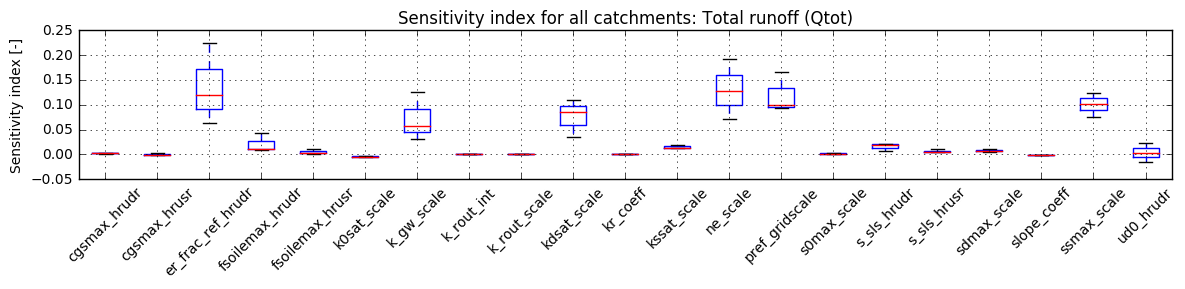

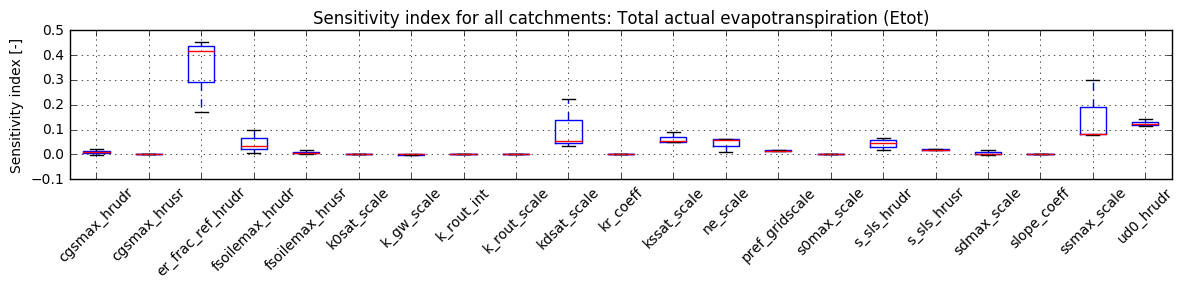

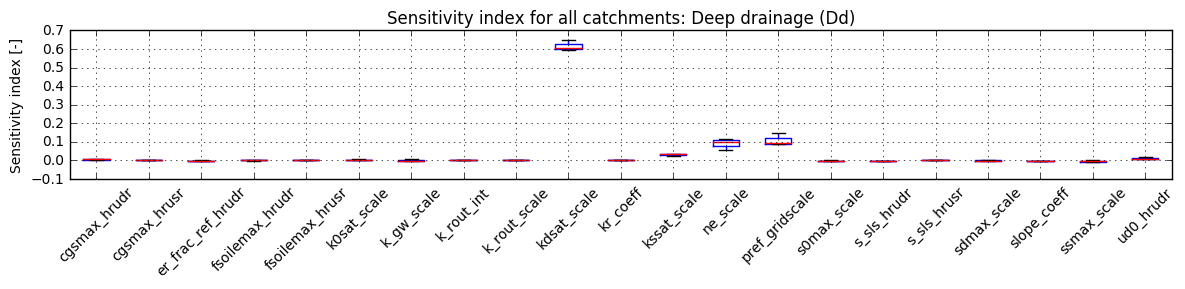

In [15]:
%matplotlib inline
#Get the sensitivities for all catchments (get_all_catchment_si), and plot their distribution
catchsens = sr.get_all_catchment_si('qtot_vol')
plt.figure(figsize=(12,3))
plt.title('Sensitivity index for all catchments: Total runoff (Qtot)')
bp = catchsens.astype(float).boxplot(return_type='axes', rot=45)
plt.ylabel('Sensitivity index [-]')
plt.tight_layout()

catchsens = sr.get_all_catchment_si('etot_vol')
plt.figure(figsize=(12,3))
plt.title('Sensitivity index for all catchments: Total actual evapotranspiration (Etot)')
bp = catchsens.astype(float).boxplot(return_type='axes', rot=45)
plt.ylabel('Sensitivity index [-]')
plt.tight_layout()

catchsens = sr.get_all_catchment_si('dd_vol')
plt.figure(figsize=(12,3))
plt.title('Sensitivity index for all catchments: Deep drainage (Dd)')
bp = catchsens.astype(float).boxplot(return_type='axes', rot=45)
plt.ylabel('Sensitivity index [-]')
plt.tight_layout()

In [16]:
# Convenience functions for plotting the sensitivity indices (si and sti) 
# sti deals with the interactions between parameters, whereas si does not
#
# Inputs: 
#       sr= sensitivity samppling results
#       param=  variable for analysis (from sr.global_keys)
#       catchment=  catchment is not specified, provides the global value, else for the specified catchment

def plot_si(sr,param,catchment=None):
    fig = plt.figure(figsize=(10,2.5))
    if catchment is not None:
        psens = sr.get_catchment_si(param,catchment)
        title = '%s (Si), catch_id: %s' % (param, catchment)
    else:
        psens = sr.get_global_si(param)
        title = '%s (Si), global' % param
    psens.plot(kind='bar',xlim=[0,psens.max()+0.1],title=title, rot=45)
    #plt.gca().invert_yaxis()
    
    print(sum(psens))
    

def plot_sti(sr,param,catchment=None):
    fig = plt.figure(figsize=(10,2.5))
    if catchment is not None:
        psens = sr.get_catchment_si(param,catchment,True)
        title = '%s (STi), catch_id: %s' % (param, catchment)
    else:
        psens = sr.get_global_si(param,True)
        title = '%s (STi), global' % param
    psens.plot(kind='bar',xlim=[0,psens.max()+0.1],title=title, rot=45)
    #plt.gca().invert_yaxis()
    print(sum(psens))    

1.0942011593
0.727580458216
1.13118944607
1.08906984489


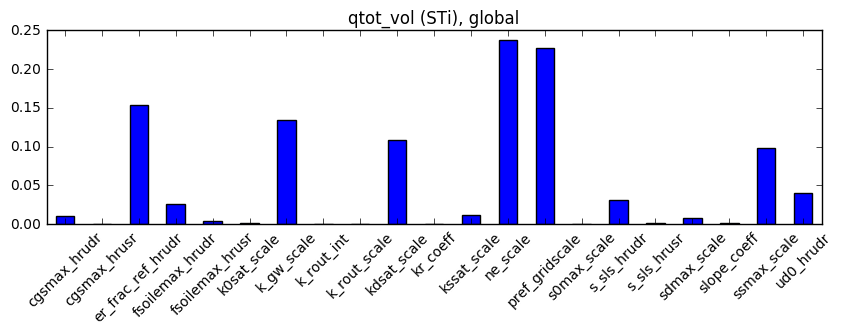

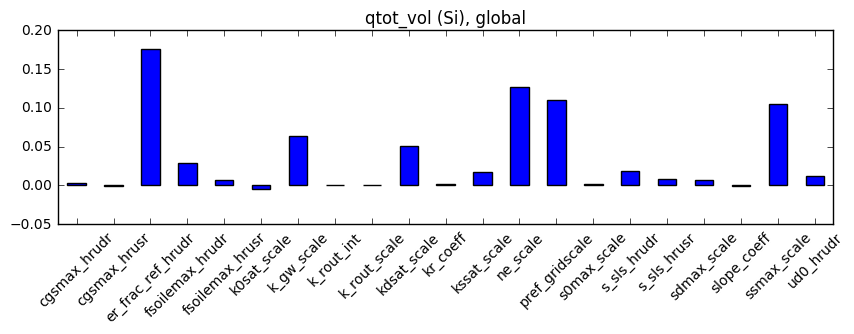

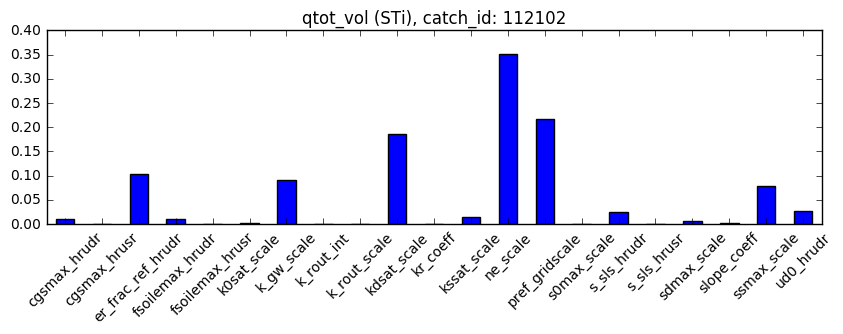

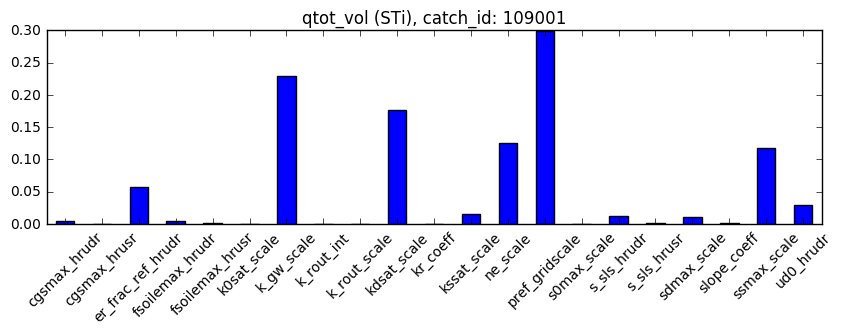

In [22]:
# Show the global sensitivity index for qtot
plot_sti(sr,'qtot_vol')
plot_si(sr,'qtot_vol')
#Get the sensitivities for individual catchments, and plot their distribution
# Show the total sensitivity index for runoff
plot_sti(sr,'qtot_vol','112102')
#Get the sensitivities for individual catchments, and plot their distribution
# Show the total sensitivity index for runoff
plot_sti(sr,'qtot_vol','109001')

1.0942011593
1.0430569204
1.09169563273


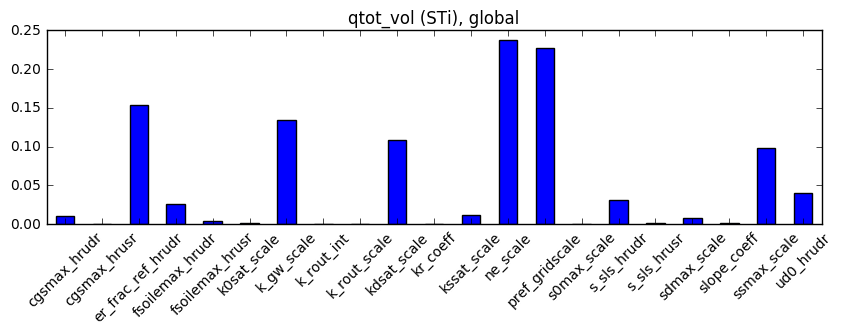

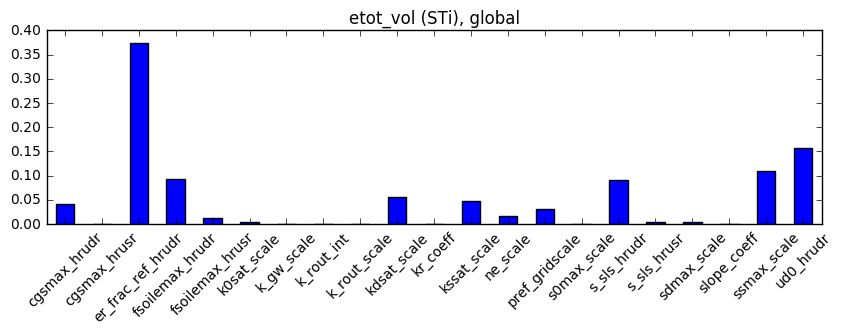

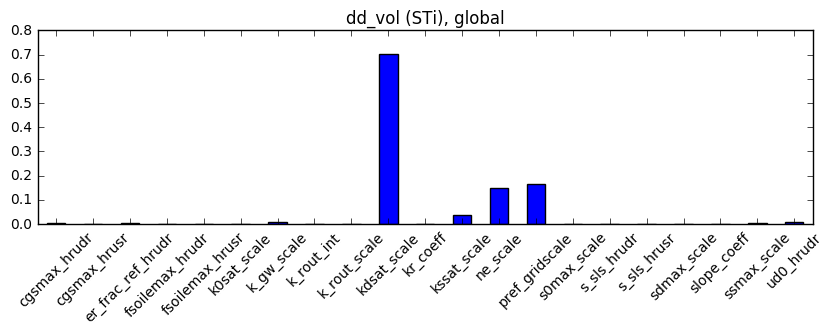

In [24]:
# Show the total sensitivity index for the three outputs
plot_sti(sr,'qtot_vol')
plot_sti(sr,'etot_vol')
plot_sti(sr,'dd_vol')